In [1]:
# imports
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from scikeras.wrappers import KerasClassifier
from datascienceutils import DataScienceUtils as dsu

import random
from tensorflow.keras import backend
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

# Importing Data

In [2]:
# use the scaled data
df = pd.read_csv('ProcessedData/train_scaled.csv')

In [4]:
# reset the index
df = df.set_index(keys='Unnamed: 0')

In [5]:
df.head()

,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,...,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Overall_Experience
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,-0.986142,0.457245,0.832354,1.522136,-1.046703,-1.660469,-0.384168,-0.261250,-0.742520,1.396646,...,-1.169832,-0.397253,-1.127589,-1.203839,-0.389006,-1.468343,0.521882,-1.479859,-1.812906,0
1,1.014053,0.457245,0.567700,1.522136,0.955380,0.215099,-0.148115,-0.390872,-1.523049,1.396646,...,-1.972154,0.367507,0.405740,1.239225,-1.173176,-2.333656,-1.065622,0.256793,0.499208,0
2,-0.986142,0.457245,0.236883,-0.656972,-1.046703,-0.892926,1.635395,2.694135,-0.742520,-0.887615,...,0.434813,1.132266,1.172405,1.239225,1.179333,1.127596,0.521882,1.125119,1.269912,1
3,-0.986142,0.457245,0.303047,-0.656972,-1.046703,-1.166284,-0.043202,0.075767,0.038010,-0.887615,...,-1.169832,-0.397253,-0.360924,-0.389484,-0.389006,-0.603030,0.521882,-0.611533,-0.271497,0
4,-0.986142,0.457245,0.700027,-0.656972,-1.046703,0.002054,-0.384168,-0.390872,0.038010,-0.126195,...,0.434813,1.132266,0.405740,0.424870,0.395163,0.262283,0.521882,0.256793,0.499208,1


# Data Preparation

## Splitting data into targets and features

In [6]:
# split data into features and target

# class
Y = df['Overall_Experience']

# features
X = df.drop(columns='Overall_Experience')

## Split the Data into test and training sets

In [15]:
# split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# Model evaluation functions

In [16]:
def train_validation_loss_plot(hist):
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [17]:
def get_best_threshold(mdl):
    
    # get the models predictions on the test set
    Y_hat: np.ndarray = mdl.predict(X_test)
    
    # keep probabilities for the positive outcomes only
    # i.e. get a 1d array of the positive outcomes only
    Y_hat: np.ndarray = Y_hat[:, 0]
    
    # calculate the roc curves
    fpr, tpr, thresholds = roc_curve(Y_test, Y_hat)
    
    # calculate the gmeans for each threshold
    gmeans: np.ndarray = np.sqrt(tpr * (1-fpr))
    
    idx: int = np.argmax(gmeans)
    
    return thresholds[idx]

In [18]:
def plot_roc_curve(mdl):
    
    # get the models predictions on the test set
    Y_hat: np.ndarray = mdl.predict(X_test)
    
    # keep probabilities for the positive outcomes only
    # i.e. get a 1d array of the positive outcomes only
    Y_hat: np.ndarray = Y_hat[:, 0]
    
    # calculate the roc curves
    fpr, tpr, thresholds = roc_curve(Y_test, Y_hat)
    
    # calculate the gmeans for each threshold
    gmeans: np.ndarray = np.sqrt(tpr * (1-fpr))
    
    idx: int = np.argmax(gmeans)
    
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[idx], gmeans[idx]))
    
    fig, ax = plt.subplots()
    
    # plot the roc curve for the model
    ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
    ax.plot(fpr, tpr, marker='.')
    ax.scatter(fpr[idx], tpr[idx], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    
    return thresholds[idx]

In [19]:
def make_confusion_matrix(mdl,threshold = 0.5):
    
    # get predictions using the test data

    # make predictions on the model
    y_pred: np.ndarray = mdl.predict(X_test)[:, 0]
    
    Y_pred_threshold: np.ndarray = (y_pred > threshold)
    
    cm = confusion_matrix(Y_test, Y_pred_threshold)

    cm[[0, 1]] = cm[[1, 0]]
    
    cm[:, [0, 1]] = cm[:, [1, 0]]

    cm_df = pd.DataFrame(cm, columns=["Predicted Leaving", "Predicted Staying"], index=["Leaving", "Staying"])
    
    TP = cm_df.loc['Leaving', 'Predicted Leaving']
    FP = cm_df.loc['Staying', 'Predicted Leaving']
    TN = cm_df.loc['Staying', 'Predicted Staying']
    FN = cm_df.loc['Leaving', 'Predicted Staying']

    precision = TP / (TP + FP)  # out of my true predictions, what percentage did I get right?
    recall = TP / (TP + FN)  # how many of people that are leaving am I discovering?
    fpr = FP / (FP + TN)  # out of the ones that are staying, how many did I predict are leaving?
    fdr = FP / (FP + TN)
    
    print(f"Precision/TPR: {precision}")
    print(f"Recall: {recall}")
    print(f"False Positive Rate: {fpr}")
    print(f"False Discovery Rate: {fdr}")

In [20]:
# now need a way to evaluate the model 
def evaluate_model(mdl, mdl_hist):
    
    print(f"Train Loss vs validation loss:\n")
    train_validation_loss_plot(mdl_hist)
    
    print(f"ROC curve for model:\n")
    threshold = plot_roc_curve(mdl)
    
    print(f"Model Confusion matrix:\n")
    make_confusion_matrix(mdl, threshold)

In [21]:
def fix_generator_seeds():
    
    # not sure what this does
    tf.keras.backend.clear_session()
    #Fix the seed for the different random number generators

    # fix seed for numpy
    np.random.seed(42)
    
    # fix seed for python
    random.seed(42)
    
    # fix seed for tensorflow
    tf.random.set_seed(42)

# Model Building

# Model 1 (Baseline model)

In [22]:
# fix the generator seed
fix_generator_seeds()

In [23]:
# initialize a sequenctial model 

mdl1 = Sequential()

In [25]:
# The amount of nodes (dimensions) in hidden layer should be the average of input and output layers, in this case 64.
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
mdl1.add(Dense(activation = 'relu', input_dim = X_train.shape[1], units=64))
#Add 1st hidden layer
mdl1.add(Dense(32, activation='relu'))
# Adding the output layer
# Notice that we do not need to specify input dim.
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
mdl1.add(Dense(1, activation = 'sigmoid'))

In [26]:
# Create optimizer with default learning rate
# Compile the model
mdl1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# inspect a summary of the model
mdl1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# fit the model
hist1 = mdl1.fit(X_train, Y_train,
          validation_split=0.2,
          epochs=50,
          batch_size=32,verbose=1)

Epoch 1/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7888 - loss: 0.4521 - val_accuracy: 0.8694 - val_loss: 0.3005
Epoch 2/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8732 - loss: 0.2946 - val_accuracy: 0.8897 - val_loss: 0.2633
Epoch 3/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8867 - loss: 0.2635 - val_accuracy: 0.8974 - val_loss: 0.2431
Epoch 4/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8952 - loss: 0.2458 - val_accuracy: 0.9027 - val_loss: 0.2314
Epoch 5/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9004 - loss: 0.2348 - val_accuracy: 0.9051 - val_loss: 0.2238
Epoch 6/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9041 - loss: 0.2272 - val_accuracy: 0.9083 - val_loss: 0.2181
Epoch 7/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9070 - loss: 0.2214 - val_accuracy: 0.9090 - val_loss: 0.2136
Epoch 8/50
1652/1652 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9087 - loss: 0.2165 - 

885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9279 - loss: 0.1696


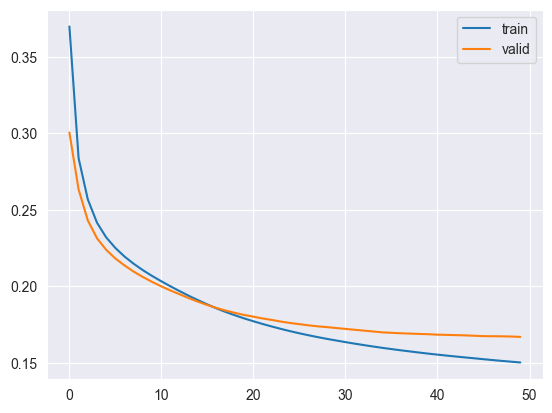

In [30]:
# Capturing learning history per epoch
hist1_df  = pd.DataFrame(hist1.history)
hist1_df['epoch'] = hist1.epoch

# Plotting accuracy at different epochs
plt.plot(hist1_df['loss'])
plt.plot(hist1_df['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = mdl1.evaluate(X_test, Y_test)

885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Best Threshold=0.486079, G-Mean=0.930


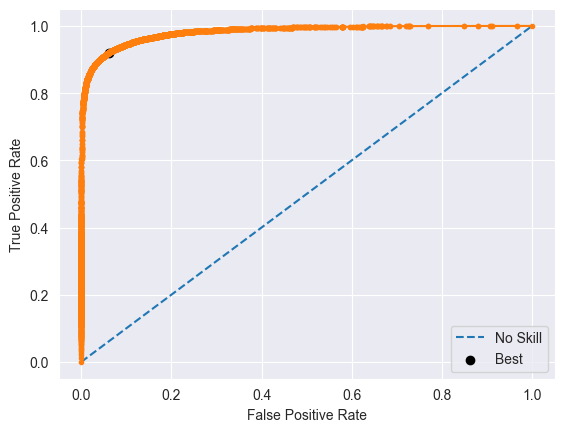

In [32]:
# plot the roc curve

threshold1 = plot_roc_curve(mdl1)

In [33]:
make_confusion_matrix(mdl1, threshold1)

885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
Precision/TPR: 0.9485528412108338
Recall: 0.9202679203967283
False Positive Rate: 0.06060843043716274
False Discovery Rate: 0.06060843043716274


In [34]:
df_assess = pd.read_csv('ProcessedData/X_test.csv')

In [35]:
df_assess.head()

,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,-0.986142,0.457245,-0.226260,-0.656972,-1.046703,-1.407540,-0.384168,-0.390872,0.038010,-0.126195,...,-0.951175,1.237135,0.367507,1.172405,1.239225,1.179333,1.127596,0.521882,1.125119,-1.812906
1,-0.986142,-2.187013,-1.218710,-0.656972,-1.046703,-0.538825,-0.148115,0.335012,-1.523049,0.635225,...,-0.191068,-1.972154,-0.397253,-0.360924,1.239225,-0.389006,0.262283,-0.271870,1.125119,-0.271497
2,1.014053,0.457245,1.361660,-0.656972,-1.046703,0.829911,-0.384168,-0.390872,1.599069,1.396646,...,1.329146,1.237135,1.132266,-1.127589,-1.203839,-1.173176,-1.468343,0.521882,-1.479859,1.269912
3,-0.986142,0.457245,-0.689404,1.522136,0.955380,-0.609840,-0.384168,-0.390872,0.038010,1.396646,...,-1.711282,-0.367510,1.132266,-1.894253,-0.389484,-1.173176,1.127596,1.315634,1.125119,-1.812906
4,1.014053,-2.187013,-1.417201,-0.656972,-1.046703,-0.358856,0.061710,-0.390872,1.599069,-0.126195,...,1.329146,1.237135,1.132266,1.172405,0.424870,-0.389006,1.127596,1.315634,1.125119,1.269912


In [37]:
df_assess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   35602 non-null  float64
 1   Customer_Type            35602 non-null  float64
 2   Age                      35602 non-null  float64
 3   Type_Travel              35602 non-null  float64
 4   Travel_Class             35602 non-null  float64
 5   Travel_Distance          35602 non-null  float64
 6   Departure_Delay_in_Mins  35602 non-null  float64
 7   Arrival_Delay_in_Mins    35602 non-null  float64
 8   Seat_Comfort             35602 non-null  float64
 9   Arrival_Time_Convenient  35602 non-null  float64
 10  Catering                 35602 non-null  float64
 11  Platform_Location        35590 non-null  float64
 12  Onboard_Wifi_Service     35602 non-null  float64
 13  Onboard_Entertainment    35602 non-null  float64
 14  Online_Support        

In [36]:
y = mdl1.predict(df_assess)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step


In [40]:
y = pd.Series(y[:, 0])

In [42]:
y = y > threshold1

In [43]:
y.head()

0     True
1    False
2     True
3    False
4     True
dtype: bool

In [44]:
y = y.astype(int)

In [45]:
y.head()

0    1
1    0
2    1
3    0
4    1
dtype: int32

In [52]:
y_df = pd.DataFrame({"Overall_Experience": y})

In [53]:
y_df.head()

,Overall_Experience
0,1
1,0
2,1
3,0
4,1


In [54]:
IDs_df = pd.read_csv('Data/Surveydata_test.csv')

IDs_df.head()

,ID,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,99900001,Acceptable,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor
1,99900002,Extremely Poor,Ordinary,Good,Poor,Manageable,Acceptable,Poor,Acceptable,Acceptable,Excellent,Acceptable,Good,Acceptable,Excellent,Acceptable
2,99900003,Excellent,Ordinary,Excellent,Excellent,Very Convenient,Excellent,Excellent,Excellent,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Needs Improvement,Excellent
3,99900004,Acceptable,Green Car,Excellent,Acceptable,Very Convenient,Poor,Acceptable,Excellent,Poor,Acceptable,Needs Improvement,Excellent,Excellent,Excellent,Poor
4,99900005,Excellent,Ordinary,Extremely Poor,Excellent,Needs Improvement,Excellent,Excellent,Excellent,Excellent,NaN,Acceptable,Excellent,Excellent,Excellent,Excellent


In [55]:
y_df["ID"] = IDs_df['ID']

In [56]:
y_df.head()

,Overall_Experience,ID
0,1,99900001
1,0,99900002
2,1,99900003
3,0,99900004
4,1,99900005


In [58]:
y_df = y_df[['ID', 'Overall_Experience']]

y_df.head()

,ID,Overall_Experience
0,99900001,1
1,99900002,0
2,99900003,1
3,99900004,0
4,99900005,1


In [59]:
y_df.to_csv('Predictions/NN_mdl1.csv', index=False)